# CAICT 風機結冰預測 - Model _ Predict Label

2017/07/23  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

### Summary

### Outline


<a id='load'></a>
## 1. Load Data and Modules

In [12]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [13]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_expo_data(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled


In [14]:
def checkPath(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

In [15]:
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(true_y, pred_y)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    prec= precision_score(true_y, pred_y)
    recall = recall_score(true_y, pred_y)
    accuracy = accuracy_score(true_y,pred_y)
    confusions = (
    ('tn', tn),
    ('fn', fn),
    ('tp', tp),
    ('fp', fp)
    )
    msg = 'Score:{sco:.2f} \n\taccuracy:{acc:.2f}, \n\trecall:{rcl:.2f}, \n\tprecision:{psc:.2f}\n\t{cfmt}'.format(sco=score,acc=accuracy,rcl=recall,psc=prec,cfmt=confusions)
    return score, accuracy, prec, recall, OrderedDict(confusions),msg

def mycv(model_log, train_X, train_y):
    skf = cross_validation.StratifiedKFold(train_y.values,10)
    score_list=[]
    accuracy_list=[]
    precision_list = []
    recall_list=[]
    for train,test in skf:
        model_log = model_log.fit(train_X.values[train],train_y.values[train])
        pred_y = model_log.predict(train_X.values[test])       
        score, accuracy, precision, recall, cmt, msg = myscore(train_y.values[test], pred_y)
        score_list.append(score)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
    msg = 'Score:{sco:.2f} \n\taccuracy:{acc:.2f}, \n\trecall:{rcl:.2f}, \n\tprecision:{psc:.2f}'.format(sco=np.mean(score_list),acc=np.mean(accuracy_list),rcl=np.mean(recall_list),psc=np.mean(precision_list))
    return np.mean(score_list), msg

In [16]:
def getPostProp(data, col_name):
    prop_Y = len(data[(data['label']==1)])/len(data)
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    prop_XgivenY_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY_dict[idx]= q/len(data_f)
    print('prop_XgivenY_dict',prop_XgivenY_dict)
    data[col_name+'_postprop1'] = data[col_name+'_categ'].apply(lambda x: prop_Y*prop_XgivenY_dict.get(x)/prop_X_dict.get(x))

def getPostProp2(data, col_name):
    prop_Y1 = len(data[(data['label']==1)])/len(data)
    prop_Y0 = len(data[(data['label']==0)])/len(data)
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    
    prop_XgivenY1_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY1_dict[idx]= q/len(data_f)
    print('prop_XgivenY1_dict',prop_XgivenY1_dict)
    
    prop_XgivenY0_dict={}
    data_p = data[data['label']==0]
    target_cnt = data_p[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY0_dict[idx]= q/len(data_p)
    print('prop_XgivenY0_dict',prop_XgivenY0_dict)
    
    data[col_name+'_postprop2'] = data[col_name+'_categ'].apply(lambda x: prop_Y1*prop_XgivenY1_dict.get(x)/(prop_Y0*prop_XgivenY0_dict.get(x) + prop_Y1*prop_XgivenY1_dict.get(x)))
    
def getPostProp3(data, col_name):
    prop_Y1 = 0.5
    prop_Y0 = 0.5
    
    prop_X_dict={}
    target_cut = pd.cut(data[col_name], np.arange(0.0, 1.1, 0.1), labels=range(10))
    data[col_name+'_categ']=target_cut
    target_cnt = target_cut.value_counts()
    for idx, q in target_cnt.items():
        prop_X_dict[idx]= q/len(data)
    #print('prop_X_dict',prop_X_dict)
    
    prop_XgivenY1_dict={}
    data_f = data[data['label']==1]
    target_cnt = data_f[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY1_dict[idx]= q/len(data_f)
    print('prop_XgivenY1_dict',prop_XgivenY1_dict)
    
    prop_XgivenY0_dict={}
    data_p = data[data['label']==0]
    target_cnt = data_p[col_name+'_categ'].value_counts()
    for idx, q in target_cnt.items():
        prop_XgivenY0_dict[idx]= q/len(data_p)
    print('prop_XgivenY0_dict',prop_XgivenY0_dict)
    
    data[col_name+'_postprop3'] = data[col_name+'_categ'].apply(lambda x: prop_Y1*prop_XgivenY1_dict.get(x)/(prop_Y0*prop_XgivenY0_dict.get(x) + prop_Y1*prop_XgivenY1_dict.get(x)))
    

***

**Load input data.** 

In [84]:
_, dat_scaled_M15 = load_expo_data(mid=15,policy=0)
_, dat_scaled_M15_train = load_expo_data(mid=15,policy=4)

dat_scaled_M15.label[dat_scaled_M15.label==2]=0.5

dat_scaled_M15_train.label[dat_scaled_M15_train.label==2] = 0.5
#dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
#dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p0_15.csv
load file: data/resample_data_p4_15.csv


/Users/jayhsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jayhsu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [123]:

xcols=['wind_speed', 'wind_direction', 'generator_speed',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC']

train_y = dat_scaled_M15_train['label']
test_y = dat_scaled_M15['label']

events = dat_scaled_M15['event'].unique()
data_predict_tmp_M15= dat_scaled_M15[['event','label']].copy()


<a id='modeling'></a>
### 3. Modeling

**windspeed**

In [229]:
x='wind_speed'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_windspeed = xgb.XGBRegressor()
xgb_windspeed = xgb_windspeed.fit(train_X,train_y)
pred_windspeed = xgb_windspeed.predict(test_X)


In [230]:
unique, counts = np.unique(pred_windspeed, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-wind_speed']=pred_windspeed
data_predict_tmp_M15['pass-wind_speed']=data_predict_tmp_M15['prop-wind_speed'].apply(lambda x: 1 if x==min_prop else 0 )



wind_speed min_prop 0.0160021


**power**

In [136]:
x='power'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_power = xgb.XGBRegressor()
xgb_power = xgb_power.fit(train_X,train_y)
pred_power = xgb_power.predict(test_X)


In [231]:
unique, counts = np.unique(pred_power, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-power']=pred_power
data_predict_tmp_M15['pass-power']=data_predict_tmp_M15['prop-power'].apply(lambda x: 1 if x==min_prop else 0 )


wind_speed min_prop 0.00425273


** yaw_position **

In [232]:
x='yaw_position'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_yaw_position = xgb.XGBRegressor()
xgb_yaw_position = xgb_yaw_position.fit(train_X,train_y)
pred_yaw_position = xgb_yaw_position.predict(test_X)


In [233]:
unique, counts = np.unique(pred_yaw_position, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-yaw_position']=pred_yaw_position
data_predict_tmp_M15['pass-yaw_position']=data_predict_tmp_M15['prop-yaw_position'].apply(lambda x: 1 if x==min_prop else 0 )


yaw_position min_prop 0.0413628


** pitch1_angle **

In [234]:
x='pitch1_angle'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch1_angle = xgb.XGBRegressor()
xgb_pitch1_angle = xgb_pitch1_angle.fit(train_X,train_y)
pred_pitch1_angle = xgb_pitch1_angle.predict(test_X)


In [235]:
unique, counts = np.unique(pred_pitch1_angle, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch1_angle']=pred_pitch1_angle
data_predict_tmp_M15['pass-pitch1_angle']=data_predict_tmp_M15['prop-pitch1_angle'].apply(lambda x: 1 if x==min_prop else 0 )


pitch1_angle min_prop 0.0103046


** pitch2_angle **

In [236]:
x='pitch2_angle'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch2_angle = xgb.XGBRegressor()
xgb_pitch2_angle = xgb_pitch2_angle.fit(train_X,train_y)
pred_pitch2_angle = xgb_pitch2_angle.predict(test_X)


In [237]:
unique, counts = np.unique(pred_pitch2_angle, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch2_angle']=pred_pitch2_angle
data_predict_tmp_M15['pass-pitch2_angle']=data_predict_tmp_M15['prop-pitch2_angle'].apply(lambda x: 1 if x==min_prop else 0 )


pitch2_angle min_prop 0.00649798


** pitch3_angle **

In [238]:
x='pitch3_angle'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch3_angle = xgb.XGBRegressor()
xgb_pitch3_angle = xgb_pitch3_angle.fit(train_X,train_y)
pred_pitch3_angle = xgb_pitch3_angle.predict(test_X)


In [239]:
unique, counts = np.unique(pred_pitch3_angle, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch3_angle']=pred_pitch3_angle
data_predict_tmp_M15['pass-pitch3_angle']=data_predict_tmp_M15['prop-pitch3_angle'].apply(lambda x: 1 if x==min_prop else 0 )


pitch3_angle min_prop 0.0122833


** pitch1_speed **

In [240]:
x='pitch1_speed'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch1_speed = xgb.XGBRegressor()
xgb_pitch1_speed = xgb_pitch1_speed.fit(train_X,train_y)
pred_pitch1_speed = xgb_pitch1_speed.predict(test_X)


In [241]:
unique, counts = np.unique(pred_pitch1_speed, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch1_speed']=pred_pitch1_speed
data_predict_tmp_M15['pass-pitch1_speed']=data_predict_tmp_M15['prop-pitch1_speed'].apply(lambda x: 1 if x==min_prop else 0 )


pitch1_speed min_prop 0.00271699


** pitch2_speed **

In [242]:
x='pitch2_speed'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch2_speed = xgb.XGBRegressor()
xgb_pitch2_speed = xgb_pitch2_speed.fit(train_X,train_y)
pred_pitch2_speed = xgb_pitch2_speed.predict(test_X)


In [243]:
unique, counts = np.unique(pred_pitch2_speed, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch2_speed']=pred_pitch2_speed
data_predict_tmp_M15['pass-pitch2_speed']=data_predict_tmp_M15['prop-pitch2_speed'].apply(lambda x: 1 if x==min_prop else 0 )


pitch2_speed min_prop 0.00314507


** pitch3_speed **

In [244]:
x='pitch3_speed'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch3_speed = xgb.XGBRegressor()
xgb_pitch3_speed = xgb_pitch3_speed.fit(train_X,train_y)
pred_pitch3_speed = xgb_pitch3_speed.predict(test_X)


In [245]:
unique, counts = np.unique(pred_pitch3_speed, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch3_speed']=pred_pitch3_speed
data_predict_tmp_M15['pass-pitch3_speed']=data_predict_tmp_M15['prop-pitch3_speed'].apply(lambda x: 1 if x==min_prop else 0 )


pitch3_speed min_prop 0.00265706


** pitch1_moto_tmp **

In [246]:
x='pitch1_moto_tmp'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch1_moto_tmp = xgb.XGBRegressor()
xgb_pitch1_moto_tmp = xgb_pitch1_moto_tmp.fit(train_X,train_y)
pred_pitch1_moto_tmp = xgb_pitch1_moto_tmp.predict(test_X)


In [247]:
unique, counts = np.unique(pred_pitch1_moto_tmp, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch1_moto_tmp']=pred_pitch1_moto_tmp
data_predict_tmp_M15['pass-pitch1_moto_tmp']=data_predict_tmp_M15['prop-pitch1_moto_tmp'].apply(lambda x: 1 if x==min_prop else 0 )


pitch1_moto_tmp min_prop 0.0401366


** pitch2_moto_tmp **

In [248]:
x='pitch2_moto_tmp'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch2_moto_tmp = xgb.XGBRegressor()
xgb_pitch2_moto_tmp = xgb_pitch2_moto_tmp.fit(train_X,train_y)
pred_pitch2_moto_tmp = xgb_pitch2_moto_tmp.predict(test_X)


In [249]:
unique, counts = np.unique(pred_pitch2_moto_tmp, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch2_moto_tmp']=pred_pitch2_moto_tmp
data_predict_tmp_M15['pass-pitch2_moto_tmp']=data_predict_tmp_M15['prop-pitch2_moto_tmp'].apply(lambda x: 1 if x==min_prop else 0 )


pitch2_moto_tmp min_prop 0.0755414


** pitch3_moto_tmp **

In [250]:
x='pitch3_moto_tmp'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_pitch3_moto_tmp = xgb.XGBRegressor()
xgb_pitch3_moto_tmp = xgb_pitch3_moto_tmp.fit(train_X,train_y)
pred_pitch3_moto_tmp = xgb_pitch3_moto_tmp.predict(test_X)


In [251]:
unique, counts = np.unique(pred_pitch3_moto_tmp, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-pitch3_moto_tmp']=pred_pitch3_moto_tmp
data_predict_tmp_M15['pass-pitch3_moto_tmp']=data_predict_tmp_M15['prop-pitch3_moto_tmp'].apply(lambda x: 1 if x==min_prop else 0 )


pitch3_moto_tmp min_prop 0.0578096


** acc_x **

In [252]:
x='acc_x'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_acc_x = xgb.XGBRegressor()
xgb_acc_x = xgb_acc_x.fit(train_X,train_y)
pred_acc_x = xgb_acc_x.predict(test_X)


In [253]:
unique, counts = np.unique(pred_acc_x, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-acc_x']=pred_acc_x
data_predict_tmp_M15['pass-acc_x']=data_predict_tmp_M15['prop-acc_x'].apply(lambda x: 1 if x==min_prop else 0 )


acc_x min_prop 0.329677


** acc_y **

In [254]:
x='acc_y'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_acc_y = xgb.XGBRegressor()
xgb_acc_y = xgb_acc_y.fit(train_X,train_y)
pred_acc_y = xgb_acc_y.predict(test_X)


In [255]:
unique, counts = np.unique(pred_acc_y, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-acc_y']=pred_acc_y
data_predict_tmp_M15['pass-acc_y']=data_predict_tmp_M15['prop-acc_y'].apply(lambda x: 1 if x==min_prop else 0 )


acc_y min_prop 0.323298


**environment_tmp**

In [256]:
x='environment_tmp'
train_X = dat_scaled_M15_train[[x]]
test_X = dat_scaled_M15[[x]]

xgb_environment_tmp = xgb.XGBRegressor()
xgb_environment_tmp = xgb_environment_tmp.fit(train_X,train_y)
pred_environment_tmp = xgb_environment_tmp.predict(test_X)


In [257]:
unique, counts = np.unique(pred_environment_tmp, return_counts=True)
cumsum_c = counts.cumsum()
min_prop = unique[np.where(cumsum_c==cumsum_c[cumsum_c>4000][0])][0]
#min_prop = unique[0]
print(x, 'min_prop',min_prop)
data_predict_tmp_M15['prop-environment_tmp']=pred_environment_tmp
data_predict_tmp_M15['pass-environment_tmp']=data_predict_tmp_M15['prop-environment_tmp'].apply(lambda x: 1 if x==min_prop else 0 )


environment_tmp min_prop 0.115017


In [177]:
'pass-wind_speed'
'pass-power'
'pass-yaw_position'
'pass-pitch1_angle'
'pass-pitch2_angle'
'pass-pitch3_angle'
'pass-pitch1_speed'
'pass-pitch2_speed'
'pass-pitch3_speed'
'pass-pitch1_moto_tmp'
'pass-pitch2_moto_tmp'
'pass-pitch3_moto_tmp'
'pass-acc_x'
'pass-acc_y'
'pass-environment_tmp'

'pass-wind_speed'

'pass-power'

'pass-yaw_position'

'pass-pitch1_angle'

'pass-pitch2_angle'

'pass-pitch3_angle'

'pass-pitch1_speed'

'pass-pitch2_speed'

'pass-pitch3_speed'

'pass-pitch1_moto_tmp'

'pass-pitch2_moto_tmp'

'pass-pitch3_moto_tmp'

'pass-acc_x'

'pass-acc_y'

'pass-environment_tmp'

In [179]:
passX = ['pass-wind_speed', 'pass-power', 'pass-yaw_position', 'pass-pitch1_angle', 'pass-pitch2_angle', 'pass-pitch3_angle', 'pass-pitch1_speed', 'pass-pitch2_speed', 'pass-pitch3_speed', 'pass-pitch1_moto_tmp', 'pass-pitch2_moto_tmp', 'pass-pitch3_moto_tmp', 'pass-acc_x', 'pass-acc_y', 'pass-environment_tmp']
passX

['pass-wind_speed',
 'pass-power',
 'pass-yaw_position',
 'pass-pitch1_angle',
 'pass-pitch2_angle',
 'pass-pitch3_angle',
 'pass-pitch1_speed',
 'pass-pitch2_speed',
 'pass-pitch3_speed',
 'pass-pitch1_moto_tmp',
 'pass-pitch2_moto_tmp',
 'pass-pitch3_moto_tmp',
 'pass-acc_x',
 'pass-acc_y',
 'pass-environment_tmp']

In [258]:
data_predict_tmp_M15['pass_sum'] = data_predict_tmp_M15[passX].sum(axis=1)

In [259]:
data_predict_tmp_M15['label'].value_counts()

0.0    350255
1.0     23892
0.5     19739
Name: label, dtype: int64

In [286]:
tmp = pd.DataFrame(data_predict_tmp_M15['pass_sum'].value_counts())
tmp = tmp.sort_index(ascending=False)
tmp['cumsum']=tmp.pass_sum.cumsum()
tmp

,pass_sum,cumsum
12,3,3
11,29,32
10,435,467
9,2151,2618
8,2802,5420
7,1085,6505
6,4107,10612
5,21272,31884
4,217456,249340
3,143684,393024


In [299]:
data_predict_tmp_M15['final_pred']=data_predict_tmp_M15['pass_sum'].apply(lambda x: 0 if x>2 else 1)
data_predict_tmp_M15['final_pred'].value_counts()

0    393024
1       862
Name: final_pred, dtype: int64

/Users/jayhsu/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


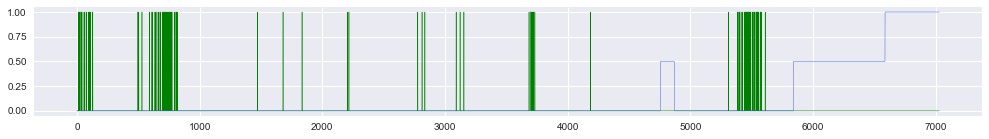

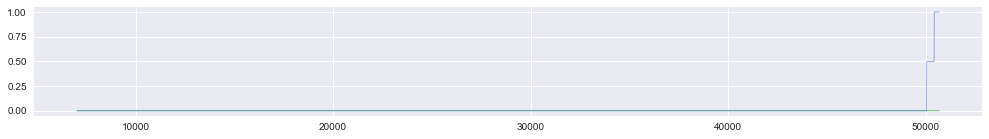

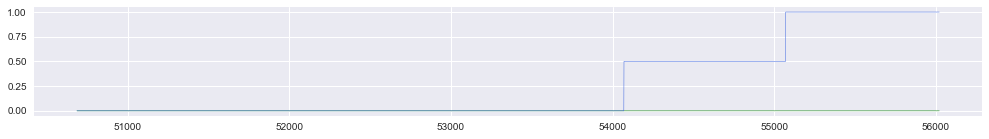

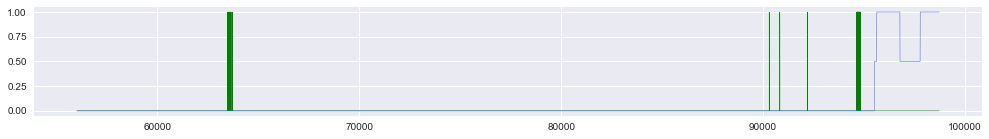

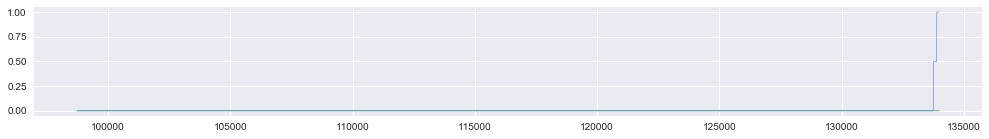

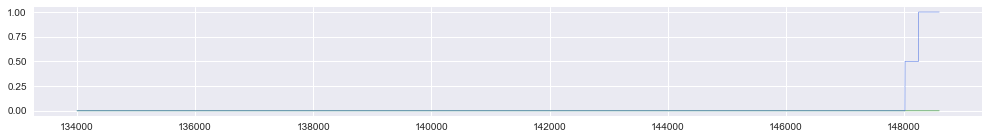

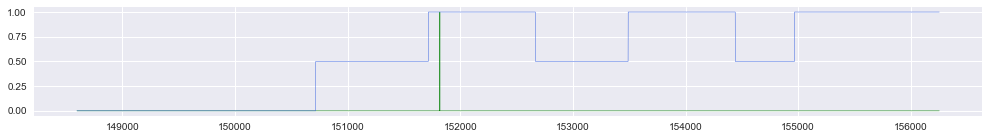

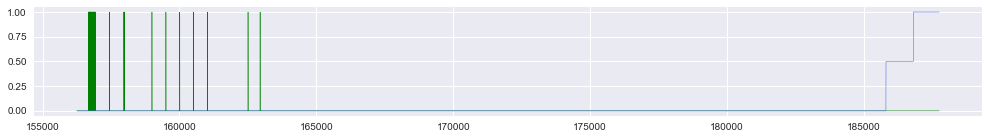

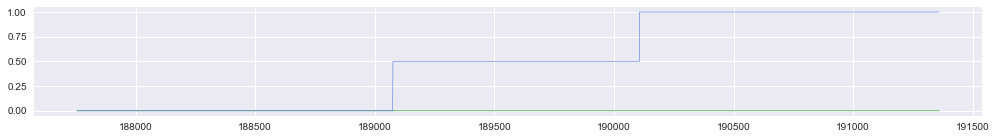

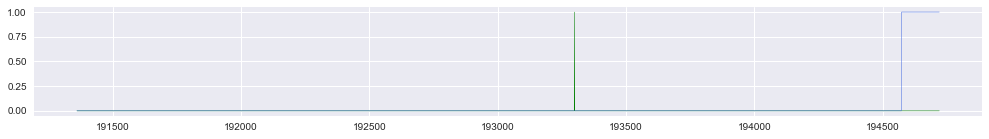

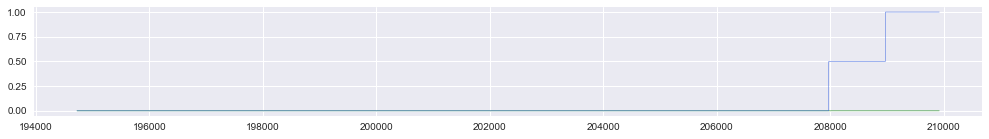

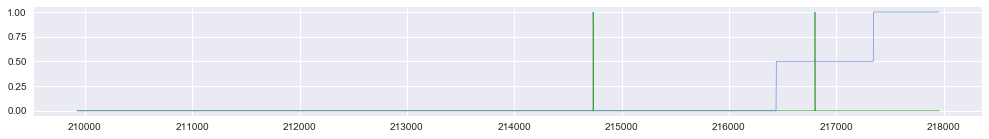

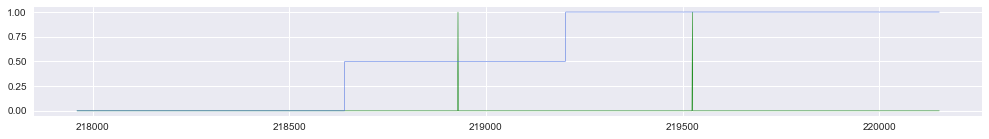

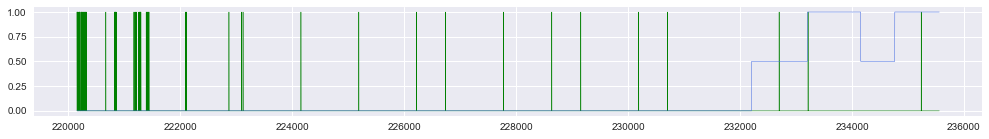

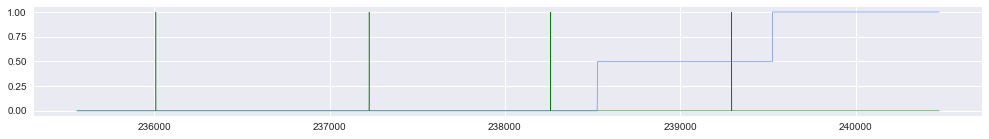

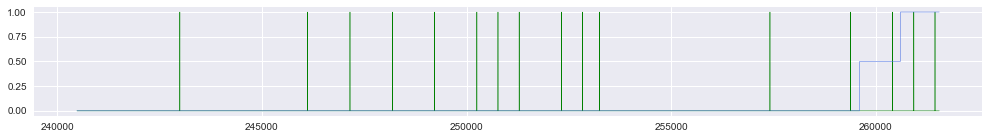

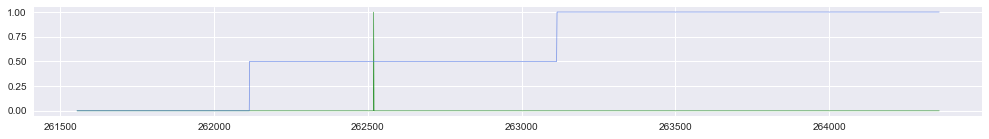

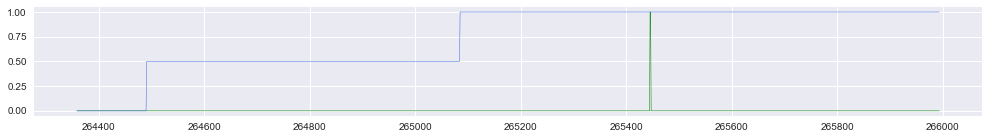

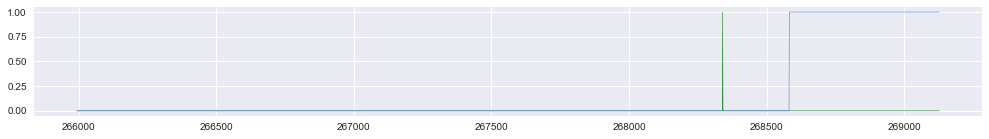

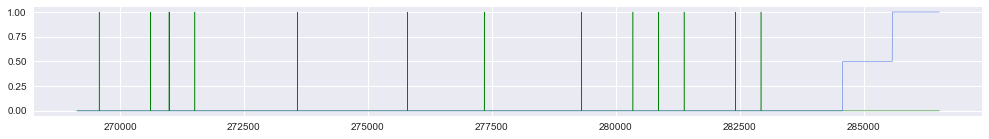

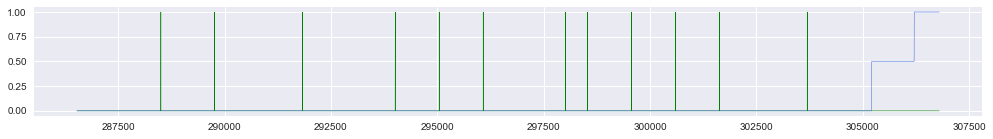

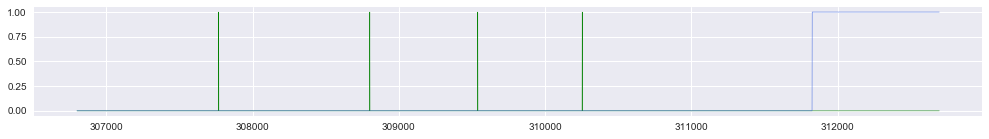

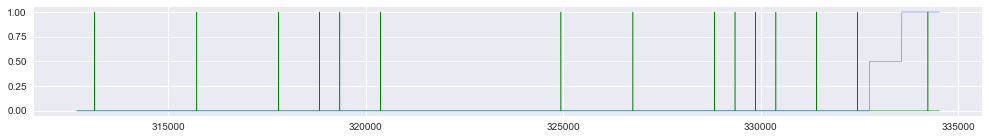

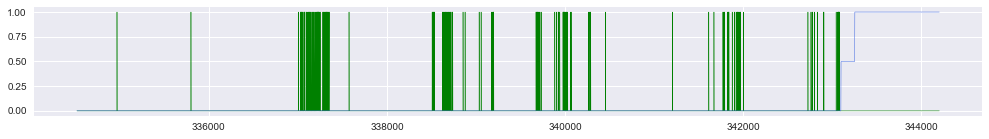

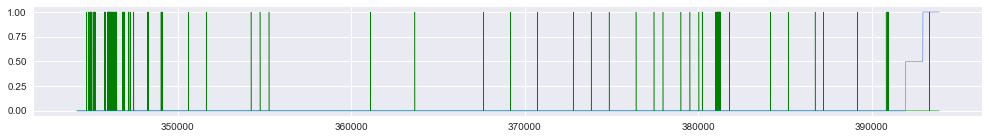

In [300]:
plot_y = data_predict_tmp_M15[['label','event','final_pred']]

for e in events:
    plot_y_e = plot_y[plot_y['event']==e]
    dummy = plt.figure(figsize=[17,2])
    plt.plot(plot_y_e['final_pred'], color = 'green', lw=0.5, label='predict')
    plt.plot(plot_y_e['label'], color = 'royalblue', lw=0.5, label='label')
#    plt.plot(plot_y_e['wind_speed'], color = 'red', lw=0.5, label='label')

***